In [1]:
# Read allophant results:
import pickle

result_files = {
    "en": "output/allophant_en_sr16000_ipa.pkl",
    "es": "output/allophant_es_sr16000_ipa.pkl",
}

results = {}
for lang, file in result_files.items():
    with open(file, "rb") as f:
        results[lang] = pickle.load(f)

In [2]:
# Show one example of each language:
for lang, data in results.items():
    print(f"Language: {lang}")
    for wav_file, res in data.items():
        print(f"Wav: {wav_file}")
        print(f"Result: {res}")
        break

Language: en
Wav: input_audios/output/words_wav/en/sr16000/rollback_en1075135_en.Jamaica.wav
Result: ['r', 'o̞ː', 'l', 'b', 'æ', 'k']
Language: es
Wav: input_audios/output/words_wav/es/sr16000/baratija_es023913_es.Castellano.wav
Result: ['b', 'a', 'ɾ', 'a', 't̪', 'i', 'x', 'a']


In [3]:
type(res)

list

In [4]:
# parse results:
import pandas as pd
from pathlib import Path

    
def parse_file_name(file_name):
    """Extract data from file_name 
    e.g. desde_es061900_es.Argentina.wav -> desde (word), es061900 (id), es.Argentina (accent)
    """
    parts = file_name.split('_')
    word = parts[0]
    id_ = parts[1]
    accent = '_'.join(parts[2:]).replace('.wav', '')
    return word, id_, accent



# Make df with cols: lang, accent, word, phone_list, id, wav_file:
def make_df(results):
    data = []
    for lang, lang_data in results.items():
        for wav_file, res in lang_data.items():
            file_name = Path(wav_file).stem
            word, id_, accent = parse_file_name(file_name)
            phones = res
            data.append({
                'lang': lang,
                'accent': accent,
                'word': word,
                'phone_list': phones,
                'id': id_,
                'wav_file': f"{file_name}.wav",
            })
    return pd.DataFrame(data)

df_phones = make_df(results)

In [5]:
df_phones.sample(6)

lang           accent             word  \
17938    en    en.Australian             tony   
98634    en  en.uk.Yorkshire  diversification   
42831    en      en.us.south            fifth   
192146   es        es.Mexico         falencia   
29690    en       en.Jamaica          splurge   
116131   en          en.scot       overcharge   

                                       phone_list            id  \
17938                                [t, ɑ, n, i]     en1090440   
98634   [d, æʌ̯, v, ə, s, ɪ, f, ɪ, k, e, ʃ, ə, n]  en1026122-55   
42831                                  [p, eː, θ]      en033792   
192146                 [f, ə, l, ɛ, n, s̪̻, i, a]      es087739   
29690                          [s, p, l, e̞, d̠ʒ]      en082603   
116131                 [o, v, ɚː, t̠ʃ, ɑ, ɹ, d̠ʒ]     en1061859   

                                                wav_file  
17938                   tony_en1090440_en.Australian.wav  
98634   diversification_en1026122-55_en.uk.Yorkshire.wav  
42831                     fifth_en033792_en.us.south.wav  
192146                   falencia_es087739_es.Mexico.wav  
29690                    splurge_en082603_en.Jamaica.wav  
116131                  overcharge_en1061859_en.scot.wav

In [6]:
# df_phones.query("word.str.endswith('pivot') & lang == 'en'").sample(6)
df_phones.query("word.str.endswith('r') & lang == 'es'").sample(6)


lang         accent          word  \
185478   es      es.Mexico   catalizador   
202354   es   es.Argentina       denegar   
181725   es      es.Mexico  interlocutor   
175381   es      es.Mexico      informar   
205125   es  es.Castellano   reconfortar   
207569   es  es.Castellano        amasar   

                                    phone_list        id  \
185478       [e̞, t̪, a, l, ɪ, z̪, a, ð, o, ɾ]  es036184   
202354                  [d̪, e, n, i, ɣ, ɑ, r]  es059261   
181725  [ɪ, n, t̪, e, r, l, o, k, ʊ, t̪, o, ɾ]  es112375   
175381                  [ɪ, n, f, o, r, m, aː]  es109420   
205125         [r, e, k, o, m, f, ɔ, ɾ, t̪, a]  es164042   
207569                         [a, m, a, s, a]  es010955   

                                      wav_file  
185478      catalizador_es036184_es.Mexico.wav  
202354       denegar_es059261_es.Argentina.wav  
181725     interlocutor_es112375_es.Mexico.wav  
175381         informar_es109420_es.Mexico.wav  
205125  reconfortar_es164042_es.Castellano.wav  
207569       amasar_es010955_es.Castellano.wav

## EDA

In [7]:
print(f"es unique words: {df_phones[df_phones['lang'] == 'es']['word'].nunique()}")
print(f"en unique words: {df_phones[df_phones['lang'] == 'en']['word'].nunique()}")

es unique words: 18795
en unique words: 18422


In [8]:
# Combinations of accents:
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

df_tmp = (
    df_phones
    .groupby(['lang', 'word'])
    .agg({'accent': lambda x: ", ".join(sorted(list(set(x))))})
    .reset_index()
    .groupby(['lang', 'accent'], as_index=False)
    .size()
    .sort_values(by=['lang', 'size'], ascending=[True, False])
)
# if freq < X, accent="others":
df_tmp.loc[df_tmp['size'] < 300, 'accent'] = 'otros'
df_tmp = (
    df_tmp
    .groupby(['lang', 'accent'])
    .agg({'size': 'sum'})
    .reset_index()
    .sort_values(by=['lang', 'size'], ascending=[True, False])
)
df_tmp

lang  \
3   en   
1   en   
4   en   
2   en   
0   en   
5   en   
6   en   
7   es   
8   es   

                                                                                                          accent  \
3                 en.Irish, en.Jamaica, en.scot, en.uk.Yorkshire, en.uk.general, en.uk.rp, en.us.south, en.us.us   
1  en.Australian, en.Irish, en.Jamaica, en.scot, en.uk.Yorkshire, en.uk.general, en.uk.rp, en.us.south, en.us.us   
4                              en.Irish, en.Jamaica, en.scot, en.uk.Yorkshire, en.uk.general, en.uk.rp, en.us.us   
2               en.Australian, en.Irish, en.Jamaica, en.scot, en.uk.Yorkshire, en.uk.general, en.uk.rp, en.us.us   
0            en.Australian, en.Irish, en.Jamaica, en.scot, en.uk.Yorkshire, en.uk.general, en.uk.rp, en.us.south   
5                           en.Irish, en.Jamaica, en.scot, en.uk.Yorkshire, en.uk.general, en.us.south, en.us.us   
6                                                                                                          otros   
7                                                                         es.Argentina, es.Castellano, es.Mexico   
8                                                                                                          otros   

    size  
3   7819  
1   7437  
4   1025  
2    936  
0    532  
5    346  
6    327  
7  18775  
8     20

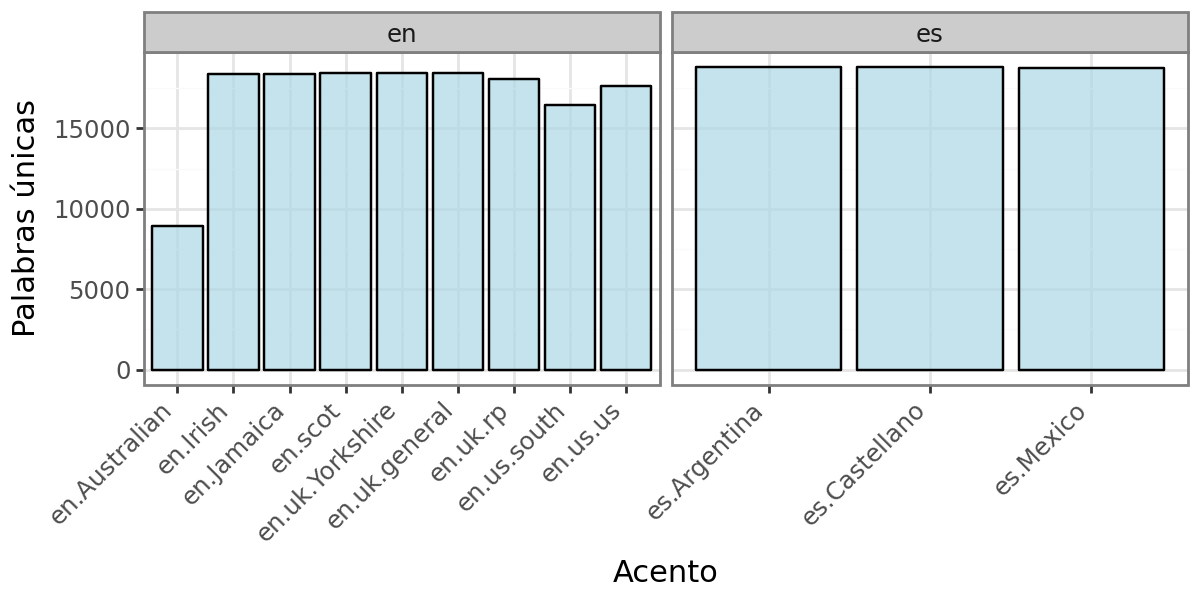

In [9]:
import plotnine as p9

df_plot = (
    df_phones
    .groupby(['lang', 'accent'])
    .agg({'word': 'nunique'})
    .reset_index()
    .rename(columns={'word': 'unique_words'})
)
p = (
    p9.ggplot(df_plot, p9.aes(x='accent', y='unique_words'))
    + p9.geom_col(fill="lightblue", color="black", alpha=.7)
    + p9.theme_bw()
    + p9.facet_wrap('~lang', scales='free_x')
    + p9.theme(
        figure_size=(6, 3),
        axis_text_x=p9.element_text(rotation=45, hjust=1),
        legend_position='bottom',
    )
    + p9.labs(x="Acento", y="Palabras únicas")
)
p.show()

## Phone distances

In [10]:
# import Levenshtein
from itertools import combinations
# from nltk.metrics.aline import delta, align
from IPython.display import Audio, display, Markdown

def play_audio(df, word, lang, accents: list = None):
    """Play audio for a given word and accent."""
    audio_path = f"output/words_wav/{lang}/sr16000"
    df_filtered = df[(df["word"] == word) & (df["lang"] == lang)]
    if accents is not None:
        df_filtered = df_filtered[df_filtered["accent"].isin(accents)]
    if df_filtered.empty:
        print(f"No audio found for word '{word}' in accents {accents}.")
    else:
        for _, row in df_filtered.iterrows():
            audio_file = f"{audio_path}/{row['wav_file']}"
            word = row["word"]
            phones_str = "".join(row["phone_list"])
            accent = row["accent"]
            display(Markdown(f"**{word}** ({accent}): [{phones_str}]"))
            # Play audio
            display(Audio(audio_file, autoplay=False))            

def my_levenshtein(a, b):
    """Because the original one fails with IPA characters"""
    n, m = len(a), len(b)
    # initialize distance matrix
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j
    # fill matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,      # deletion
                dp[i][j - 1] + 1,      # insertion
                dp[i - 1][j - 1] + cost  # substitution
            )
    return dp[n][m]

def make_distances_df(df, lang='en'):
    # Create df with cols: word, accents (N cols), phones:
    df_words = (
        df
        .query(f"lang == '{lang}'")
        .pivot_table(
            index=["word", "id"],
            columns="accent",
            values="phone_list",
            aggfunc="first",
        )
        .reset_index()
    )
    # df_words.query("word == 'usa'")
    accent_cols = [col for col in df_words.columns if col not in ['word', 'id']]
    results = []
    for _, row in df_words.iterrows():
        word = row['word']
        wordid = row['id']
        for acc1, acc2 in combinations(accent_cols, 2):
            phones1 = row[acc1]
            phones2 = row[acc2]
            if not (isinstance(phones1, list) and isinstance(phones2, list)):
                l_dist = k_dist = None
            elif len(phones1) == 0 or len(phones2) == 0:
                l_dist = k_dist = None
            else:
                # phone_str_1 = "".join(phones1)
                # phone_str_2 = "".join(phones2)
                # l_dist = Levenshtein.distance(phone_str_1, phone_str_2)
                l_dist = my_levenshtein(phones1, phones2)
                # k_dist = delta(phones1, phones2)  # TODO this fails!
            results.append({
                'word': word,
                'wordid': wordid,
                'accent1': acc1,
                'accent2': acc2,
                'phones1': phones1,
                'phones2': phones2,
                'l_dist': l_dist,
                # 'kondrak_distance': k_dist, # TODO this fails!
                # 'n_phones': TODO, # using phone_list
            })
            # if word == "zucchini":
            # # if wordid == "en100165-55":
            #     print(f"Word: {word}, Accents: {acc1}, {acc2}, Phones: {row[acc1]}, {row[acc2]}, Levenshtein: {l_dist}")
    df_dist = pd.DataFrame(results)
    return df_dist

In [11]:
df_dist_en = make_distances_df(df_phones, lang='en')
df_dist_en["lang"] = 'en'
df_dist_es = make_distances_df(df_phones, lang='es')
df_dist_es["lang"] = 'es'

df_dist = pd.concat([df_dist_en, df_dist_es], ignore_index=True)

In [12]:
df_dist_en.sort_values(by='l_dist', ascending=False)

word       wordid        accent1        accent2  \
429410        faq    en1032377  en.Australian        en.scot   
429431        faq    en1032377        en.scot       en.uk.rp   
429423        faq    en1032377     en.Jamaica        en.scot   
429432        faq    en1032377        en.scot    en.us.south   
429430        faq    en1032377        en.scot  en.uk.general   
...           ...          ...            ...            ...   
1326379  zucchini  en100165-55  en.uk.general    en.us.south   
1326380  zucchini  en100165-55  en.uk.general       en.us.us   
1326381  zucchini  en100165-55       en.uk.rp    en.us.south   
1326382  zucchini  en100165-55       en.uk.rp       en.us.us   
1326383  zucchini  en100165-55    en.us.south       en.us.us   

                                                               phones1  \
429410                                             [e, f, æʌ̯, k̟, iː]   
429431   [f, ɹ, i, k, w, ə, n, d, l̪, ɨ, ø̞, s, k, w, ɛ, s, t̠ʃ, ɨ, n]   
429423                                            [ɛ, f, e, k̟, j, uː]   
429432   [f, ɹ, i, k, w, ə, n, d, l̪, ɨ, ø̞, s, k, w, ɛ, s, t̠ʃ, ɨ, n]   
429430   [f, ɹ, i, k, w, ə, n, d, l̪, ɨ, ø̞, s, k, w, ɛ, s, t̠ʃ, ɨ, n]   
...                                                                ...   
1326379                                                            NaN   
1326380                                                            NaN   
1326381                                                            NaN   
1326382                                                            NaN   
1326383                                                            NaN   

                                                               phones2  \
429410   [f, ɹ, i, k, w, ə, n, d, l̪, ɨ, ø̞, s, k, w, ɛ, s, t̠ʃ, ɨ, n]   
429431                                           [ɛu, θ, e, k̟, j, uː]   
429423   [f, ɹ, i, k, w, ə, n, d, l̪, ɨ, ø̞, s, k, w, ɛ, s, t̠ʃ, ɨ, n]   
429432                                      [ɛ, f, æʌ̯, i, k̟, iu̜, ʊ]   
429430                                             [ɛu, f, æʌ̯, k, uː]   
...                                                                ...   
1326379                                                            NaN   
1326380                                                            NaN   
1326381                                                            NaN   
1326382                                                            NaN   
1326383                                                            NaN   

         l_dist lang  
429410     19.0   en  
429431     19.0   en  
429423     19.0   en  
429432     18.0   en  
429430     18.0   en  
...         ...  ...  
1326379     NaN   en  
1326380     NaN   en  
1326381     NaN   en  
1326382     NaN   en  
1326383     NaN   en  

[1326384 rows x 8 columns]

In [13]:
df_dist_en.query("l_dist == 2").sample(2)

word     wordid        accent1   accent2  \
1232022  underachieve  en1093310  en.uk.general  en.uk.rp   
268448       credence  en1020523  en.uk.general  en.us.us   

                                 phones1                          phones2  \
1232022  [ʌ, n, d, ɚː, ɹ, ɛu, t̠ʃ, ɨ, v]  [ʌ, n, d̪, ɵ, ɹ, ɛu, t̠ʃ, ɨ, v]   
268448             [k, ɻ, i, d, ɨ, n, z]           [k, ɻ, i, d, ə, n, ts]   

         l_dist lang  
1232022     2.0   en  
268448      2.0   en

In [14]:
# Add relative distance:
df_dist_clean = df_dist.dropna(subset=['l_dist']).copy()
df_dist_clean["max_len"] = df_dist_clean.apply(lambda x: max(len(x['phones1']), len(x['phones2'])), axis=1)
df_dist_clean["l_dist_norm"] = df_dist_clean["l_dist"] / df_dist_clean["max_len"]

In [15]:
df_tmp = df_dist_clean.query("lang == 'es'").query("l_dist_norm > .5")
df_tmp.sample(20)

word    wordid        accent1        accent2  \
1366106    pareja  es143329  es.Castellano      es.Mexico   
1375712   sheriff  es177727  es.Castellano      es.Mexico   
1380907      vaya  es197027   es.Argentina      es.Mexico   
1380050    tumbar  es194173  es.Castellano      es.Mexico   
1343604    desdén  es061965   es.Argentina  es.Castellano   
1382560     ánimo  es012975   es.Argentina      es.Mexico   
1368286     playa  es151222   es.Argentina      es.Mexico   
1340858    correa  es052027  es.Castellano      es.Mexico   
1326952   abrigar  es001470   es.Argentina      es.Mexico   
1360071    lumbar  es121927   es.Argentina  es.Castellano   
1367797     pieza  es149403   es.Argentina      es.Mexico   
1368999    postín  es153819   es.Argentina  es.Castellano   
1364760  ofensivo  es138231   es.Argentina  es.Castellano   
1345562   diálogo  es066128  es.Castellano      es.Mexico   
1374053     rodar  es171827  es.Castellano      es.Mexico   
1345974      duro  es070632   es.Argentina  es.Castellano   
1345259  disgusto  es068139  es.Castellano      es.Mexico   
1329673       amo  es011481   es.Argentina      es.Mexico   
1358243    jersey  es115041  es.Castellano      es.Mexico   
1344056  desnudez  es063730  es.Castellano      es.Mexico   

                             phones1                    phones2  l_dist lang  \
1366106          [p, ə, ɾ, i, x, a̟]         [p, a, r, e, x, a]     4.0   es   
1375712         [ʂ, i, ɛu, ɗ, iː, f]           [ʃ, ɛ, r, iː, f]     4.0   es   
1380907                [v, ɑ, zʲ, a]              [ɓ, a, ɟʝ, a]     3.0   es   
1380050                [ʊ̃, m, β, ɑ]               [ʊ, m, b, a]     3.0   es   
1343604              [ð, e, v, ɛ, n]       [d̪, ə, s, t̪, e, n]     5.0   es   
1382560            [a̟, n, i, m, õ]            [a, n, ɪ, m, o]     3.0   es   
1368286              [l, a̟, ʒʲ, a̟]              [l, a, ɟʝ, a]     3.0   es   
1340858                 [o, r, i, a]            [k, ɔ, r, e, a]     3.0   es   
1326952        [a, β, ɾ, ɪ, ɣ, a, r]        [a̟, b, r, i, ɡ, a]     6.0   es   
1360071             [l, ʊ̃, m, ɓ, a]            [l, ʊ, m, b, æ]     3.0   es   
1367797               [j, ɛ, s̪̻, a]          [p, i, e, s̪̻, a]     3.0   es   
1368999          [β, o, θ, t̪, i, n]           [ɔ, s, t̪, ɪ, n]     4.0   es   
1364760   [o, f, e, n, s̪̻, ɪ, β, o]  [ɔ, f, ɨ, n, s, iː, β, ɵ]     5.0   es   
1345562          [ð, ɪ, a̟, l, o, k]      [ð, i, a, l, o, ɣ, o]     4.0   es   
1374053             [ɾ, r, o, d̪, æ]               [r, o, ð, a]     3.0   es   
1345974               [d̪, ʊ, ɾ, oː]             [d̪, uː, ɗ, o]     3.0   es   
1345259  [ð, ɪ, s̪̻, ɣ, ʊ, s, t̪, o]  [ð, ɨ, z̪, ɡ, u, s, t, o]     5.0   es   
1329673                  [a̟, m, õ]                  [a, m, o]     2.0   es   
1358243        [ʔ, ɛ, d, au, s, æʌ̯]         [d̠ʒ, e̞, r, s, ɪ]     5.0   es   
1344056     [d̪, ə, s, n, ʊ, ð, æʌ̯]  [ð, e, z, n, uː, ð, e, s]     6.0   es   

         max_len  l_dist_norm  
1366106        6     0.666667  
1375712        6     0.666667  
1380907        4     0.750000  
1380050        4     0.750000  
1343604        6     0.833333  
1382560        5     0.600000  
1368286        4     0.750000  
1340858        5     0.600000  
1326952        7     0.857143  
1360071        5     0.600000  
1367797        5     0.600000  
1368999        6     0.666667  
1364760        8     0.625000  
1345562        7     0.571429  
1374053        5     0.600000  
1345974        4     0.750000  
1345259        8     0.625000  
1329673        3     0.666667  
1358243        6     0.833333  
1344056        8     0.750000

In [16]:
play_audio(df_phones, "chusma", "es")


**chusma** (es.Castellano): [t̠ʃʊsma]

**chusma** (es.Argentina): [t̠ʃʲʊme̞]

**chusma** (es.Mexico): [t̠ʃuːz̪me̞]

In [17]:
df_tmp = df_dist_clean.query("lang == 'en'").query("l_dist_norm > .5")
df_tmp.sample(10)

word     wordid        accent1        accent2  \
492582      general   en037980  en.uk.general       en.uk.rp   
636193       jaguar  en1048722  en.Australian     en.Jamaica   
640451       jingle  en1049035       en.Irish  en.uk.general   
747466   monumental  en1057441       en.uk.rp       en.us.us   
152313    bumblebee  en1011821       en.uk.rp    en.us.south   
573201      humdrum  en1043095       en.Irish        en.scot   
435347         feel   en033379    en.us.south       en.us.us   
326761        dingy   en025134        en.scot       en.us.us   
869504         pond   en065254  en.uk.general       en.us.us   
1283994     warbler  en1097795     en.Jamaica       en.uk.rp   

                              phones1                           phones2  \
492582        [ʃ, æʌ̯, n, ɚː, ɹ, ai̯]              [d̠ʒ, æʌ̯, n, r̪, o]   
636193           [d̠ʒ, æ, ɡ, i, w, ə]                   [d̠ʒ, a̟, ɡ, o]   
640451                 [d̠ʒ, ɪ, ŋ, ɠ]               [t̠ʃ, ɪ, ŋ, ɡ, ai̯]   
747466   [m, o, nʲ, y, m, e, n, t, o]  [m, a, n, j, ɵ, m, ɛ, n, t, æʌ̯]   
152313           [e̞, m, ɓ, aɪ, b, i]            [β, ɐ̃, m, ɓ, ɓ, e, j]   
573201        [h, o̞, m, d, r, o̞, m]                 [ɒ, m, d̠ʒ, o, m]   
435347                      [θ, e, o]                         [f, ɨ, l]   
326761                 [ɜ̃, ŋ, ʒʲ, ɪ]                 [d, ɛ, ŋ, d̠ʒ, i]   
869504                      [a, n, d]                      [p, ɑ, n, ɗ]   
1283994             [w, o̞, b, l, ɚː]                 [b, u, b, l, ai̯]   

         l_dist lang  max_len  l_dist_norm  
492582      4.0   en        6     0.666667  
636193      4.0   en        6     0.666667  
640451      3.0   en        5     0.600000  
747466      6.0   en       10     0.600000  
152313      5.0   en        7     0.714286  
573201      5.0   en        7     0.714286  
435347      3.0   en        3     1.000000  
326761      4.0   en        5     0.800000  
869504      3.0   en        4     0.750000  
1283994     3.0   en        5     0.600000

In [18]:
play_audio(df_phones, "funky", "en", accents=["en.us.south", "en.Jamaica"])

**funky** (en.us.south): [fæ̃ŋkɪ]

**funky** (en.Jamaica): [fõːŋk̟i]

In [19]:
play_audio(df_phones, "anxious", "en", accents=["en.Jamaica", "en.us.us"])

**anxious** (en.Jamaica): [a̟ŋʃo̞s̪̻]

**anxious** (en.us.us): [eŋt̠ʃɚːs]

In [20]:
play_audio(df_phones, "dot", "en")


**dot** (en.Jamaica): [dɔʀt]

**dot** (en.uk.general): [ɑːt]

**dot** (en.Irish): [aːr̝]

**dot** (en.us.us): [ɟʝɑt]

**dot** (en.uk.rp): [ot]

**dot** (en.scot): [do̞kt̪]

**dot** (en.uk.Yorkshire): [o̞t]

**dot** (en.us.south): [d̪ɑːr]

In [21]:
# Avg rel distance:
avg_rel_dist = df_dist_clean.groupby(["lang", "accent1", "accent2"])["l_dist_norm"].mean().reset_index()
avg_rel_dist = avg_rel_dist.sort_values(by="l_dist_norm", ascending=False)
avg_rel_dist.head(10)

lang        accent1        accent2  l_dist_norm
20   en        en.scot    en.us.south     0.527315
2    en  en.Australian        en.scot     0.513059
23   en  en.uk.general    en.us.south     0.488045
18   en        en.scot  en.uk.general     0.483563
5    en  en.Australian    en.us.south     0.480799
25   en       en.uk.rp    en.us.south     0.475033
1    en  en.Australian     en.Jamaica     0.474636
21   en        en.scot       en.us.us     0.470016
19   en        en.scot       en.uk.rp     0.469233
16   en     en.Jamaica    en.us.south     0.469062

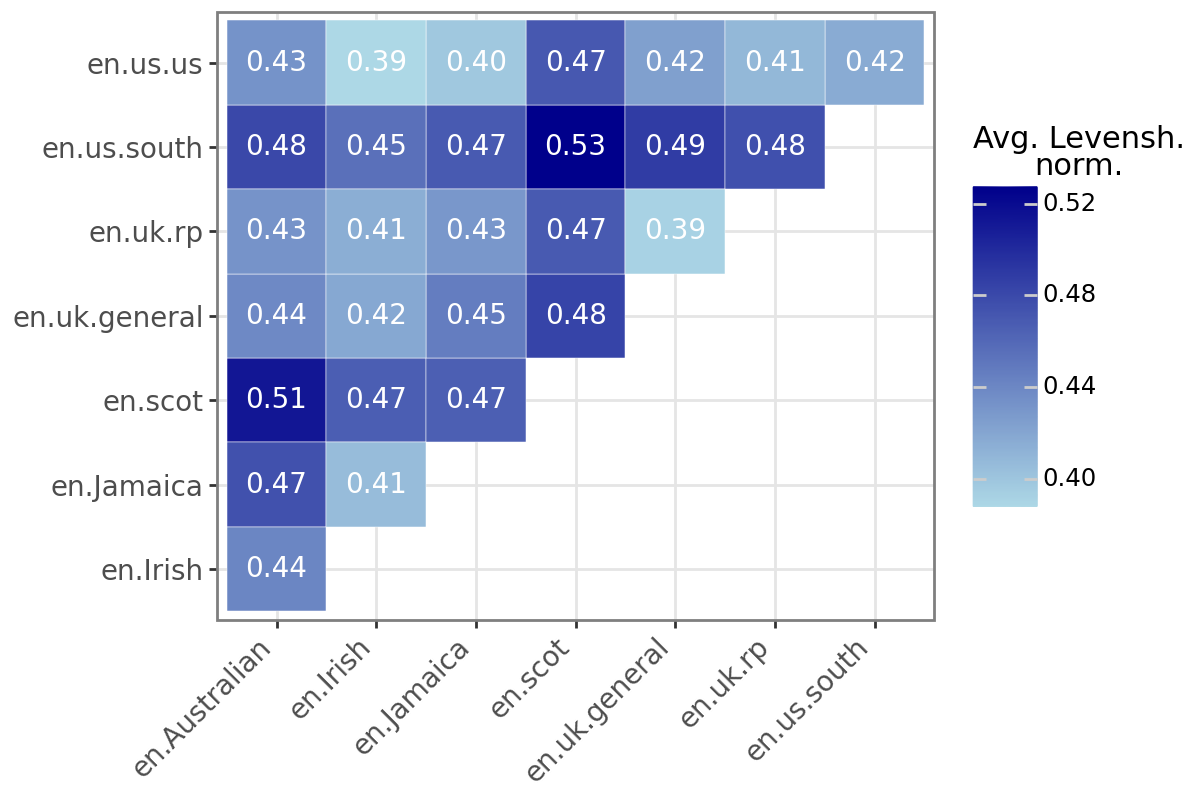

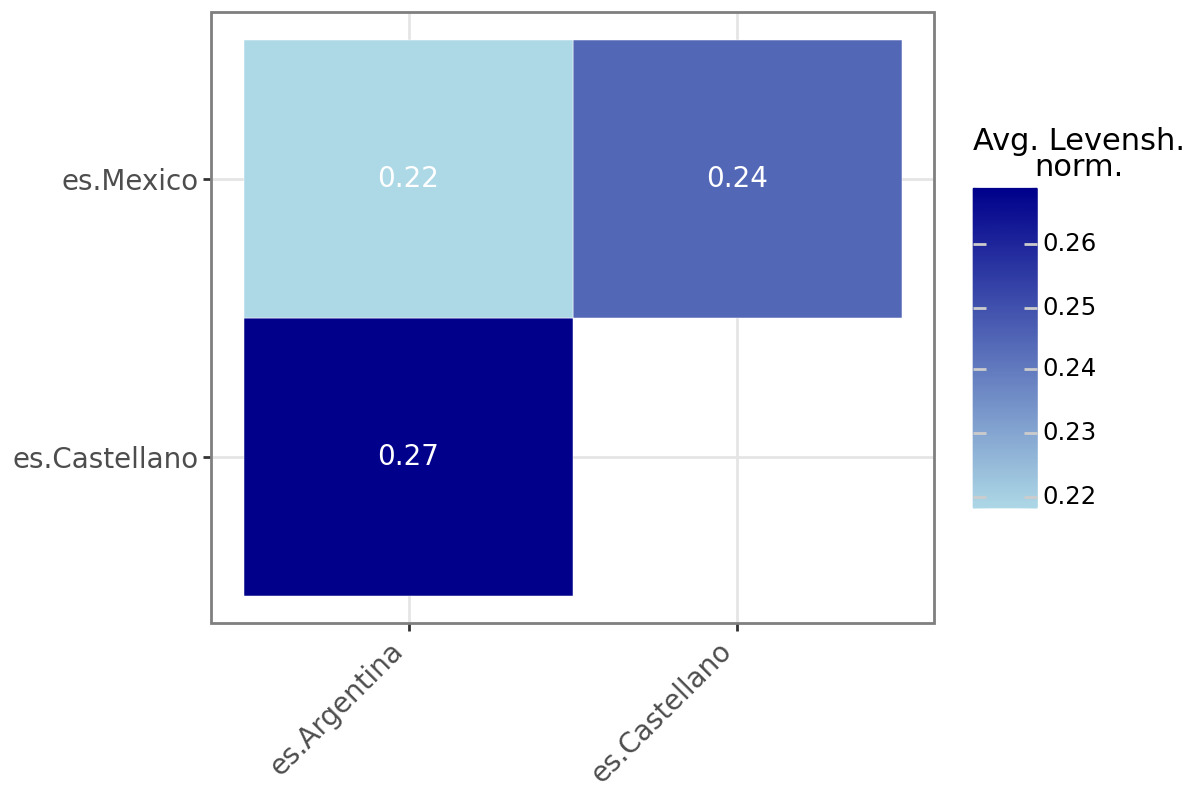

In [22]:
# Make a heatmap of the average relative distance:
import plotnine as p9

def heatmap(df, lang):
    df_plot = df.query(f"lang == '{lang}'").copy()
    df_plot["text"] = df_plot["l_dist_norm"].apply(lambda x: f"{x:.2f}")
    p = (
        p9.ggplot(df_plot, p9.aes(x='accent1', y='accent2', fill='l_dist_norm'))
        + p9.geom_tile(color='white')
        + p9.geom_text(p9.aes(label='text'), size=10, color='white')
        + p9.scale_fill_gradient(name='Avg. Levensh.\nnorm.', low='lightblue', high='darkblue')
        + p9.theme_bw()
        + p9.theme(
            figure_size=(6, 4),
            legend_position='right',
            axis_text_x=p9.element_text(rotation=45, hjust=1, size=10),
            axis_text_y=p9.element_text(size=10),
        )
        + p9.labs(x="", y="")
    )
    p.show()

heatmap(avg_rel_dist, lang='en')
heatmap(avg_rel_dist, lang='es')

## Logistic

In [23]:
import numpy as np
import pandas as pd
import plotnine as p9
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, Markdown, Audio


def contains_subsequence(data, pattern):
    m, n = len(data), len(pattern)
    if n == 0:
        return True   # empty pattern “always” matches
    if n > m:
        return False  # pattern longer than data can’t match
    # slide a window of length n over data
    for i in range(m - n + 1):
        if data[i:i+n] == pattern:
            return True
    return False

def coef_plot(df_coefs, stats_per_class, top_n=5, ncol=1):
    df_plot = df_coefs.groupby("accent").head(top_n).reset_index(drop=True).copy()
    # Make a label for each accent as: "accent\n(recall, rel_freq)"
    df_plot["accent_label"] = df_plot["accent"].apply(
        lambda x: f"{x}\n(recall: {stats_per_class[x][0]:.2f}, freq: {stats_per_class[x][1]:.2f})"
    )
    nrow = int(np.ceil(len(df_plot["accent"].unique()) / ncol))
    p = (
        p9.ggplot(
            df_plot,
            p9.aes(x="coef", y="reorder(phone+'::'+accent_label, coef)")
        )
        + p9.geom_segment(
            p9.aes(xend=0, yend="reorder(phone+'::'+accent_label, coef)"),
            color="navy", size=1, alpha=0.5
        )
        + p9.geom_point(size=1, color="navy")
        + p9.facet_wrap("accent_label", scales="free_y", ncol=ncol)
        + p9.scale_y_discrete(labels=lambda lst: [l.split("::")[0] for l in lst])
        + p9.theme_bw()
        + p9.theme(
            figure_size=(2 * ncol, 1.5 * nrow),
            axis_text_x=p9.element_text(rotation=45, hjust=1),
            axis_text_y=p9.element_text(size=10),
        )
        + p9.labs(
            y="", x="",
        )
        
    )
    return df_plot, p

def most_distinctive_phones(df, ngram_range=(1,1), min_freq=10):
    """Return a df of logistic regression coefficients for each phone
    for each accent, using n-grams of size ngram_order.
    Also return dict accent: (recall, rel_freq).
    """
    vectorizer = CountVectorizer(
        lowercase=False,
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=ngram_range,
        min_df=min_freq,     # Minimum document frequency
        binary=True,  # Binary counts (presence/absence of n-grams)
    )

    X_vectorized = vectorizer.fit_transform(df["phone_list"].values)
    y = df["accent"].values
    model = LogisticRegression(max_iter=1000, random_state=33)
    model.fit(X_vectorized, y)
    coefs = model.coef_ 
    # print accuracy:
    maj_class_freq = pd.Series(y).value_counts(normalize=True).max()
    print(f"Accuracy: {model.score(X_vectorized, y):.3f} (maj class freq: {maj_class_freq:.3f})")
    # If binary, add first line with negative coefficients:
    if len(model.classes_) == 2:
        coefs = np.vstack([-coefs[0], coefs])
    df_coefs = pd.DataFrame(
        coefs.T, 
        index=vectorizer.get_feature_names_out(),
        columns=model.classes_,
    ).reset_index().rename(columns={"index": "phone"})
    # To long format:
    df_coefs_long = df_coefs.melt(id_vars=["phone"], var_name="accent", value_name="coef")
    df_coefs_long = df_coefs_long.sort_values(by=["accent", "coef"], ascending=[True, False])
    # Make dict accent: (recall, rel_freq)
    pred = model.predict(X_vectorized)
    stats_per_class = {}
    for cl in model.classes_:
        recall = np.mean(pred[y == cl] == cl)
        rel_freq = np.mean(y == cl)
        stats_per_class[cl] = (recall, rel_freq)
    return df_coefs_long, stats_per_class

def show_examples(df, phone_ngram, lang, accent, wavs_path="output/words_wav/en/sr16000", seed=33, n=3):
    """For a given phone ngram (list of phones in order) and an accent,
    show examples of words and their audios.
    """
    df_accent = df[(df["accent"] == accent) & (df["lang"] == lang)].copy()
    df_filtered = df_accent[df_accent["phone_list"].apply(lambda x: contains_subsequence(x, phone_ngram))]
    if df_filtered.empty:
        print(f"No examples found for phone ngram {phone_ngram} in accent {accent}.")
    else:
        df_filtered = df_filtered.sample(n=min(n, len(df_filtered)), random_state=seed)
        for _, row in df_filtered.iterrows():
            word = row["word"]
            phones_str = "".join(row["phone_list"])
            audio_file = f"{wavs_path}/{row['wav_file']}"
            display(Markdown(f"{phone_ngram} as in **{word}** ({accent}): [{phones_str}]"))
            display(Audio(audio_file, autoplay=False))

def run_everything(df, ngram_range=(1,1), lang="es", accents=None, seed=33, ncol=1):
    audio_path = f"output/words_wav/{lang}/sr16000"
    df_filtered = df[df["lang"] == lang].copy()
    if accents is None:
        accents = df_filtered["accent"].unique().tolist()
    df_filtered = df_filtered[df_filtered["accent"].isin(accents)].copy()
    df_coefs, stats_per_class = most_distinctive_phones(df_filtered, ngram_range=ngram_range, min_freq=10)
    # # vec, mod = most_distinctive_phones(df_filtered, ngram_order=ngram_order)
    # return vec, mod
    df_plot, p = coef_plot(df_coefs, stats_per_class, top_n=5, ncol=ncol)
    p.show()
    for _, row in df_plot.iterrows():
        phone_ngram = row["phone"].split(" ")
        accent = row["accent"]
        # print(row)
        # print()
        show_examples(df, phone_ngram, lang, accent, wavs_path=audio_path, seed=seed, n=1)

### Español

Accuracy: 0.481 (maj class freq: 0.333)


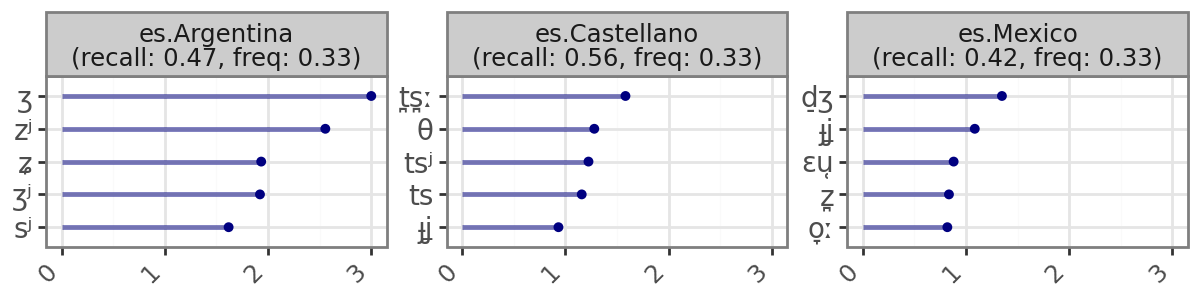

['ʒ'] as in **anillo** (es.Argentina): [a̟nɪʒõː]

['zʲ'] as in **enrollar** (es.Argentina): [ənrɔzʲɑ]

['ʑ'] as in **alcantarillado** (es.Argentina): [alkant̪aɾiʑaðo]

['ʒʲ'] as in **embotelladora** (es.Argentina): [əmβɔt̪əʒʲaðoɾa]

['sʲ'] as in **cajeta** (es.Argentina): [asʲit̪a]

['t̪s̪ː'] as in **berberecho** (es.Castellano): [berberet̪s̪ːo]

['θ'] as in **incentivar** (es.Castellano): [ɪnθent̪ɪβaɾ]

['tsʲ'] as in **quitamanchas** (es.Castellano): [ɪt̪ame̞ntsʲes̪̻]

['ts'] as in **mapache** (es.Castellano): [ma̟patse]

['ɟʝ'] as in **yogur** (es.Castellano): [ɟʝoːkʊ]

['d̠ʒ'] as in **conllevar** (es.Mexico): [kond̠ʒeva]

['ɟʝ'] as in **husillo** (es.Mexico): [ʊsɪɟʝo]

['ɛu̜'] as in **empeorar** (es.Mexico): [empɛu̜oɾa]

['z̪'] as in **luctuoso** (es.Mexico): [lʊkt̪ʊa̟z̪o]

['o̞ː'] as in **hoya** (es.Mexico): [o̞ːɟʝə]

In [24]:
run_everything(df_phones, ngram_range=(1, 1), lang="es", ncol=3)

Accuracy: 0.540 (maj class freq: 0.333)


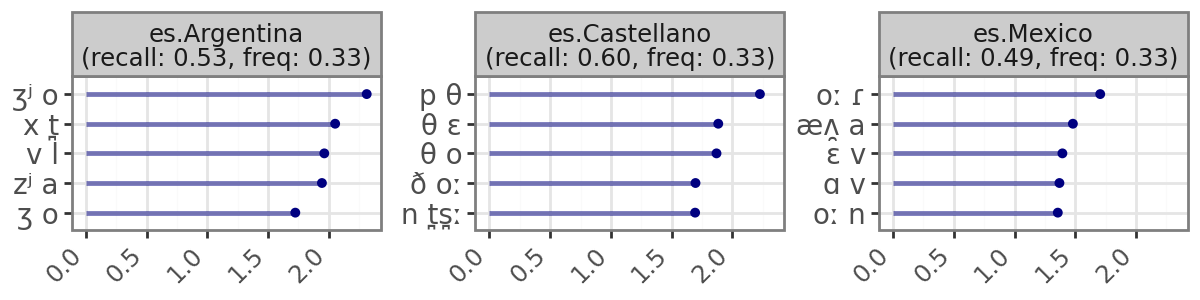

['ʒʲ', 'o'] as in **colmillo** (es.Argentina): [kolmɪʒʲo]

['x', 't̪'] as in **persistir** (es.Argentina): [æʌ̯sɪxt̪iː]

['v', 'l'] as in **venerable** (es.Argentina): [venɪd̪avle]

['zʲ', 'a'] as in **cayado** (es.Argentina): [azʲaðo]

['ʒ', 'o'] as in **pocillo** (es.Argentina): [os̪̻s̪̻ɪʒo]

['p', 'θ'] as in **erupción** (es.Castellano): [eðʊpθɪon]

['θ', 'ɛ'] as in **estremecer** (es.Castellano): [ɛst̪ɾəmeθɛ]

['θ', 'o'] as in **escorzo** (es.Castellano): [eskoɾθo]

['ð', 'oː'] as in **sólido** (es.Castellano): [solɪðoː]

['n', 't̪s̪ː'] as in **balanza** (es.Castellano): [balant̪s̪ːa]

['oː', 'ɾ'] as in **orín** (es.Mexico): [oːɾɪn]

['æʌ̯', 'a'] as in **gimotear** (es.Mexico): [hɨmo̞t̪æʌ̯a]

['ɛ', 'v'] as in **nueva** (es.Mexico): [nʊɛva]

['ɑ', 'v'] as in **puñalada** (es.Mexico): [ʊɲalɑva]

['oː', 'n'] as in **tronar** (es.Mexico): [roːna]

In [25]:
run_everything(df_phones, ngram_range=(2, 2), lang="es", ncol=3)

In [26]:
# run_everything(df_phones, ngram_range=(3, 3), lang="es", ncol=3)

### English

Accuracy: 0.333 (maj class freq: 0.120)


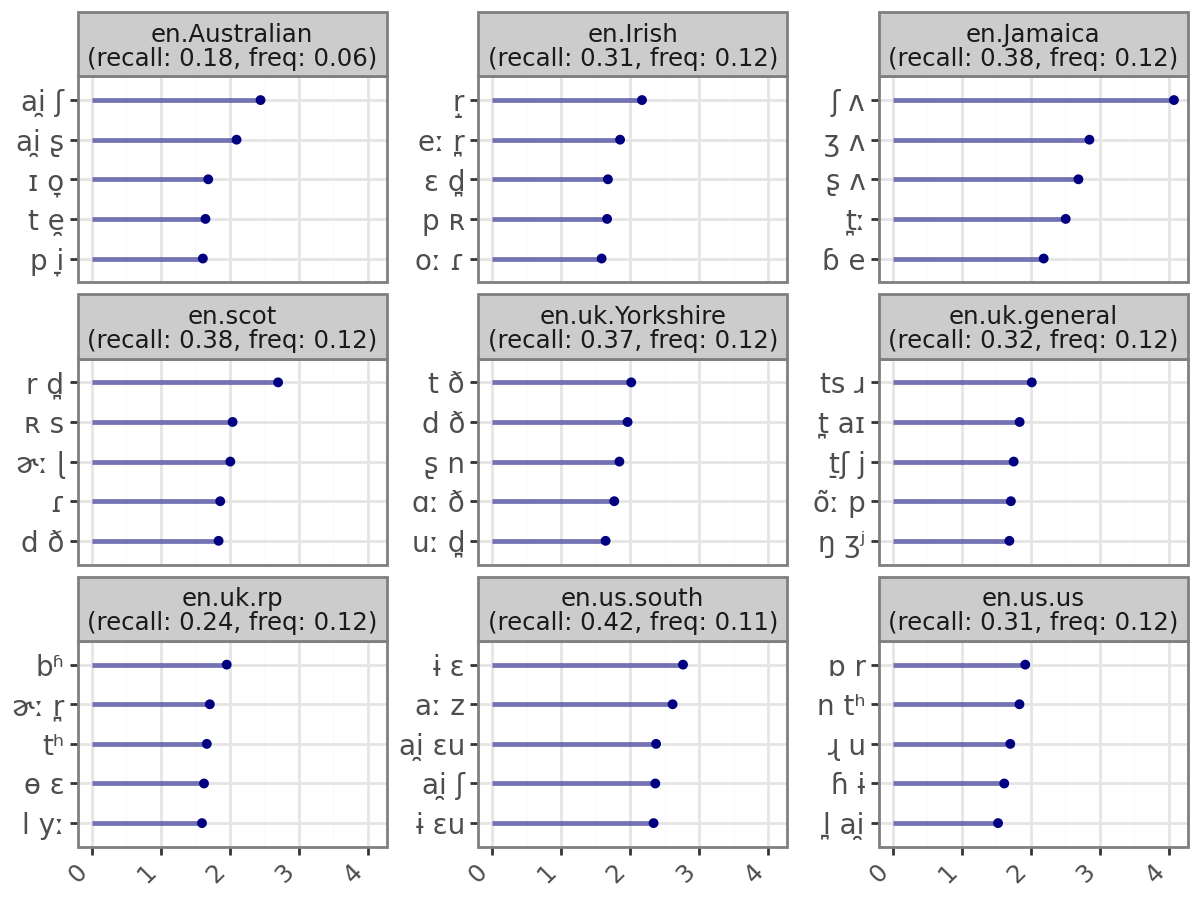

['ai̯', 'ʃ'] as in **coordination** (en.Australian): [uːɔːdɪnai̯ʃən]

['ai̯', 'ʂ'] as in **inauguration** (en.Australian): [ɪno̞ɡjʊɹai̯ʂɨn]

['ɪ', 'o̞'] as in **periodic** (en.Australian): [pir̪ɪo̞dik]

['t', 'e̯'] as in **affectation** (en.Australian): [ɛufɛːkte̯ʃən]

['p', 'i̞'] as in **happenstance** (en.Australian): [hø̞pi̞nste̞ndz]

['r̝'] as in **cannot** (en.Irish): [ke̞nɑːr̝]

['eː', 'r̪'] as in **sparing** (en.Irish): [speːr̪ɪŋ]

['ɛ', 'd̪'] as in **withers** (en.Irish): [wɛd̪ɚːz]

['p', 'ʀ'] as in **push** (en.Irish): [pʀɔʃ]

['oː', 'ɾ'] as in **curettage** (en.Irish): [kioːɾe̞taɪʒ]

['ʃ', 'ʌ'] as in **trustworthy** (en.Jamaica): [ʃʌstwe̞ðɨ]

['ʒ', 'ʌ'] as in **circumcision** (en.Jamaica): [səkʌmsiʒʌn]

['ʂ', 'ʌ'] as in **exemption** (en.Jamaica): [ɛuɡz̪ɛmpʂʌn]

['t̪ː'] as in **split** (en.Jamaica): [s̪̻plæʌ̯t̪ː]

['ɓ', 'e'] as in **barely** (en.Jamaica): [ɓelɨ]

['r', 'd̪'] as in **girdle** (en.scot): [ɡ̟ærd̪o]

['ʀ', 's'] as in **coercive** (en.scot): [k̟wɛʀsœv]

['ɚː', 'ɭ'] as in **wanderer** (en.scot): [wʌnd̪ɚːɭɚː]

['ɾ'] as in **silvery** (en.scot): [seu̯ʊ̃ŋvɾe]

['d', 'ð'] as in **indecisive** (en.scot): [e̞ndðəsæʌ̯sɪv]

['t', 'ð'] as in **advocate** (en.uk.Yorkshire): [naʊnɛudðɵko̞tðəβɛudvɵke̯t]

['d', 'ð'] as in **advocate** (en.uk.Yorkshire): [naʊnɛudðɵko̞tðəβɛudvɵke̯t]

['ʂ', 'n'] as in **rationalize** (en.uk.Yorkshire): [ɹe̞ʂnæʌ̯z]

['ɑː', 'ð'] as in **farthest** (en.uk.Yorkshire): [fɑːðɚːst]

['uː', 'd̪'] as in **poodle** (en.uk.Yorkshire): [uːd̪õ]

['ts', 'ɹ'] as in **intrepid** (en.uk.general): [ɪntsɹɛpɨd]

['t̪', 'aɪ'] as in **metal** (en.uk.general): [mɛt̪aɪ]

['t̠ʃ', 'j'] as in **amateur** (en.uk.general): [a̟me̞t̠ʃja̟]

['õː', 'p'] as in **topical** (en.uk.general): [t̠ʃõːpikɔː]

['ŋ', 'ʒʲ'] as in **injured** (en.uk.general): [ɪŋʒʲet]

['bʱ'] as in **perished** (en.uk.rp): [bʱe̞ɻɛʃd]

['ɚː', 'r̪'] as in **literate** (en.uk.rp): [leɭɚːr̪æʌ̯t]

['tʰ'] as in **tasting** (en.uk.rp): [tʰæʌ̯stɪŋ]

['ɵ', 'ɛ'] as in **whatsoever** (en.uk.rp): [wʌtsɵɛvɚː]

['l', 'yː'] as in **salute** (en.uk.rp): [s̪̻elyːʈ]

['ɨ', 'ɛ'] as in **involve** (en.us.south): [ɦɨɛnvɒld]

['aː', 'z'] as in **sympathize** (en.us.south): [sempəθaːz]

['ai̯', 'ɛu'] as in **photograph** (en.us.south): [fodeu̯ɡɹai̯ɛuf]

['ai̯', 'ʃ'] as in **exhilaration** (en.us.south): [ɛuɡzæʌ̯lɚːɹai̯ʃɨn]

['ɨ', 'ɛu'] as in **insurer** (en.us.south): [ɨɛunʃœːɚː]

['ɒ', 'r'] as in **parka** (en.us.us): [pɒrkə]

['n', 'tʰ'] as in **untapped** (en.us.us): [ɔntʰæpd]

['ɻ', 'u'] as in **scrutinize** (en.us.us): [skɻutnæʌ̯z]

['ɦ', 'ɨ'] as in **elusive** (en.us.us): [ɦɨluːsɪð]

['l̪', 'ai̯'] as in **latest** (en.us.us): [l̪ai̯dɪst]

In [27]:
run_everything(df_phones, ngram_range=(1, 2), lang="en", ncol=3)
# NOTE if binary, the coeff for the negative class are the negative of the overall coeffs.
# So the left plot displays the largest negative coefficients in absolute value.

Accuracy: 0.229 (maj class freq: 0.120)


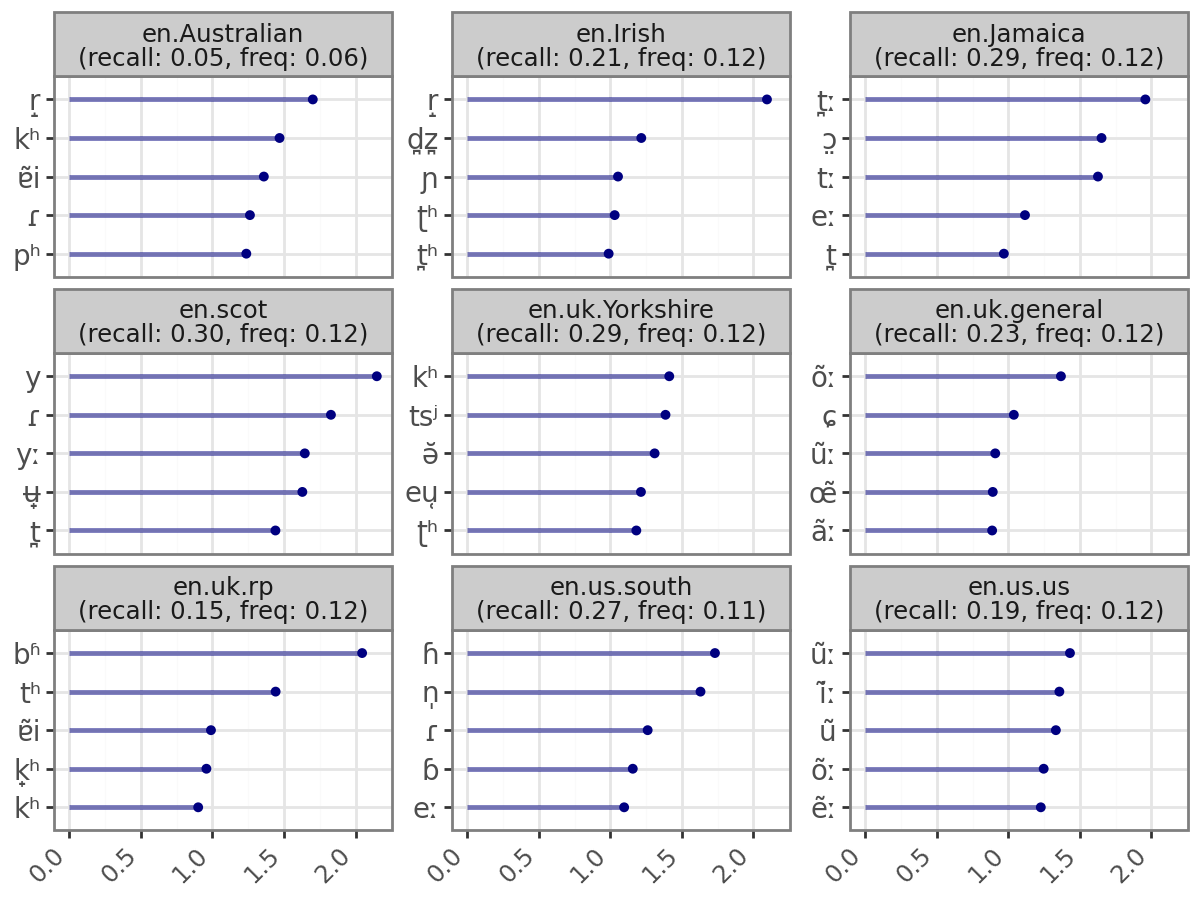

['r̝'] as in **kinesthetic** (en.Australian): [iːneu̯st̪ɛr̝ek]

['kʰ'] as in **condescension** (en.Australian): [kʰo̞ndɪsɛnʂɨn]

['ɐ̃i'] as in **snowdrop** (en.Australian): [snɐ̃idɻɑːp]

['ɾ'] as in **formidable** (en.Australian): [fɔwmeɾavol]

['pʰ'] as in **poncho** (en.Australian): [pʰɒnt̠ʃʲæʌ̯r]

['r̝'] as in **cannot** (en.Irish): [ke̞nɑːr̝]

['d̪z̪'] as in **flimsy** (en.Irish): [flɛmd̪z̪i]

['ɲ'] as in **bologna** (en.Irish): [əloɲa̟]

['ʈʰ'] as in **tantrum** (en.Irish): [ʈʰæntzʌm]

['t̪ʰ'] as in **tornado** (en.Irish): [t̪ʰo̞ːnai̯ɗɵ]

['t̪ː'] as in **split** (en.Jamaica): [s̪̻plæʌ̯t̪ː]

['ɔ̤'] as in **cost** (en.Jamaica): [kɔ̤st]

['tː'] as in **refit** (en.Jamaica): [r̪iːfæʌ̯tː]

['eː'] as in **stale** (en.Jamaica): [steːl]

['t̪'] as in **subterfuge** (en.Jamaica): [sʌt̪ɚːfjuːd̠ʒ]

['y'] as in **brood** (en.scot): [bryd̪]

['ɾ'] as in **silvery** (en.scot): [seu̯ʊ̃ŋvɾe]

['yː'] as in **moody** (en.scot): [myːdi]

['ʉ̟'] as in **to** (en.scot): [t̪ʉ̟]

['t̪'] as in **theme** (en.scot): [t̪im]

['kʰ'] as in **cook** (en.uk.Yorkshire): [kʰo̞k]

['tsʲ'] as in **glitter** (en.uk.Yorkshire): [litsʲa̟]

['ə̆'] as in **blessed** (en.uk.Yorkshire): [naunblæʌ̯sə̆fəblæʌ̯st]

['eu̜'] as in **usable** (en.uk.Yorkshire): [jeu̜ze̞ɓo]

['ʈʰ'] as in **tacit** (en.uk.Yorkshire): [ʈʰe̞sid]

['õː'] as in **gallbladder** (en.uk.general): [õːplætə]

['ɕ'] as in **dementia** (en.uk.general): [ɨme̞nɕə]

['ũː'] as in **sword** (en.uk.general): [smũːd]

['œ̃'] as in **outdoor** (en.uk.general): [œ̃toʀ]

['ãː'] as in **tiara** (en.uk.general): [ɪãːɻe̞]

['bʱ'] as in **perished** (en.uk.rp): [bʱe̞ɻɛʃd]

['tʰ'] as in **tasting** (en.uk.rp): [tʰæʌ̯stɪŋ]

['ɐ̃i'] as in **ira** (en.uk.rp): [ɐ̃iɐ̃r̪æʌ̯j]

['k̟ʰ'] as in **keystone** (en.uk.rp): [k̟ʰistaun]

['kʰ'] as in **keynote** (en.uk.rp): [kʰɨnaut]

['ɦ'] as in **installation** (en.us.south): [ɦiɪnstɛulai̯ʃɨn]

['n̩'] as in **impinge** (en.us.south): [eu̯mpiːe̯n̩d̠ʒ]

['ɾ'] as in **modal** (en.us.south): [moɾai̯]

['ɓ'] as in **embody** (en.us.south): [emɓarɪ]

['eː'] as in **peck** (en.us.south): [peːk]

['ũː'] as in **removal** (en.us.us): [ʀɔmũːvo]

['ĩː'] as in **lewd** (en.us.us): [lĩːŋudɨ]

['ũ'] as in **clue** (en.us.us): [klũm]

['õː'] as in **pulp** (en.us.us): [põːp]

['ẽː'] as in **flamenco** (en.us.us): [flɵmẽːŋkau̜]

In [28]:
run_everything(df_phones, ngram_range=(1, 1), lang="en", ncol=3)
# NOTE if binary, the coeff for the negative class are the negative of the overall coeffs.
# So the left plot displays the largest negative coefficients in absolute value.

### Pairwise performance

In [29]:
def logistic_accuracy(df):
    vectorizer = CountVectorizer(
        lowercase=False,
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1, 2),
        min_df=10,
        binary=True,
    )
    X_vectorized = vectorizer.fit_transform(df["phone_list"].values)
    y = df["accent"].values
    model = LogisticRegression(max_iter=1000, random_state=33)
    model.fit(X_vectorized, y)
    acc = model.score(X_vectorized, y)
    n_features = X_vectorized.shape[1]
    return acc, n_features

def pairwise_performance_df(df, lang='en', accents=None):
    df_filtered = df[df["lang"] == lang].copy()
    if accents is None:
        accents = df_filtered["accent"].unique().tolist()
    df_filtered = df_filtered[df_filtered["accent"].isin(accents)].copy()
    accent_pairs = combinations(accents, 2)
    results = []
    for acc1, acc2 in accent_pairs:
        # Keep only rows with the two and words in common:
        df_pair = df_filtered[(df_filtered["accent"] == acc1) | (df_filtered["accent"] == acc2)].copy()
        common_words = df_pair["word"].unique()
        df_pair = df_pair[df_pair["word"].isin(common_words)].copy()
        if df_pair.empty:
            print(f"No common words for accents {acc1} and {acc2}.")
            continue
        acc, n_features = logistic_accuracy(df_pair)
        maj_class_freq = df_pair["accent"].value_counts(normalize=True).max()
        n = len(df_pair)
        results.append({
            'accent1': acc1,
            'accent2': acc2,
            'accuracy': acc,
            'maj_class_freq': maj_class_freq,
            'n': n,
            'n_features': n_features,
        })
    df_results = pd.DataFrame(results)
    return df_results


In [30]:
df_acc_en = pairwise_performance_df(df_phones, lang='en')
df_acc_es = pairwise_performance_df(df_phones, lang='es')

In [31]:
df_acc_en["rel_acc"] = df_acc_en["accuracy"] / df_acc_en["maj_class_freq"]
df_acc_es["rel_acc"] = df_acc_es["accuracy"] / df_acc_es["maj_class_freq"]

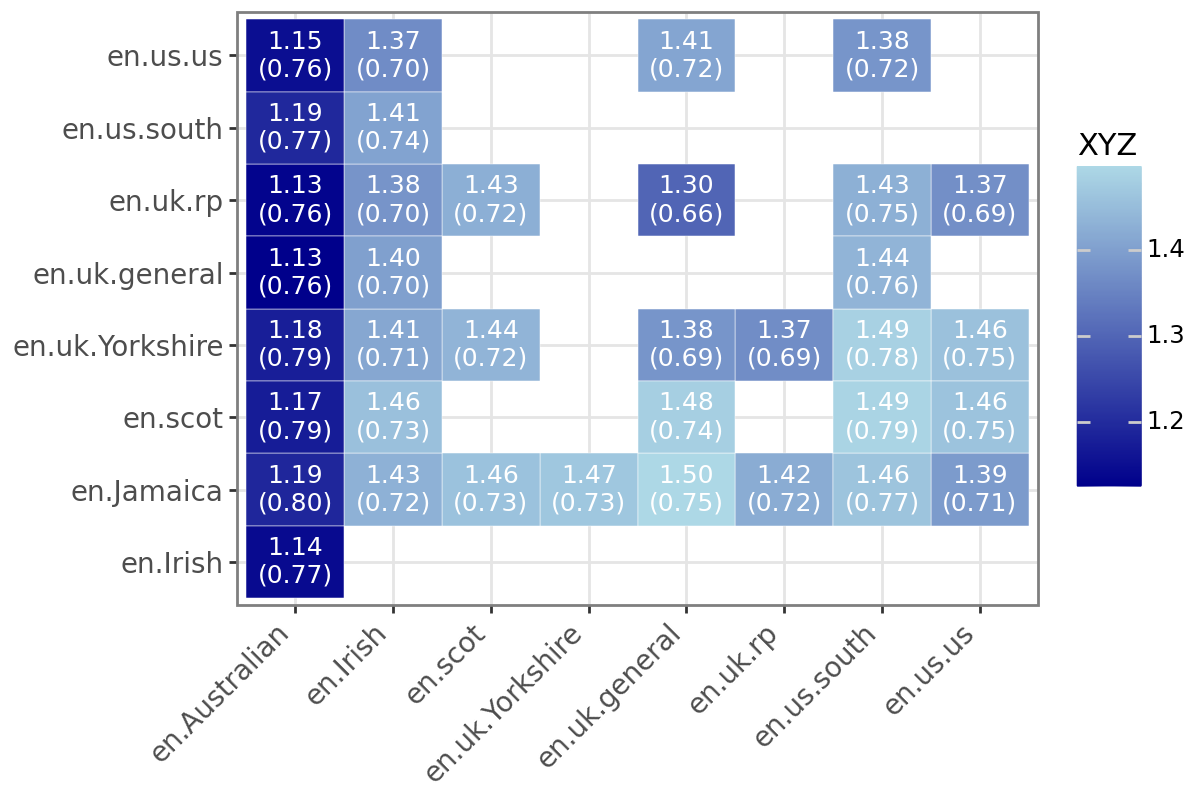

In [32]:
def heatmap(df):
    df_plot = df.copy()
    # accents = sorted(df_plot["accent1"].unique())
    # df_plot["accent1"] = pd.Categorical(df_plot["accent1"]) #, categories=accents) #, ordered=True)
    # df_plot["accent2"] = pd.Categorical(df_plot["accent2"]) #, categories=accents) #, ordered=True)
    df_plot["text"] = df_plot.apply(lambda d: f"{d['rel_acc']:.2f}\n({d['accuracy']:.2f})", axis=1)
    # return df_plot
    p = (
        p9.ggplot(df_plot, p9.aes(x='accent2', y='accent1', fill='rel_acc'))
        + p9.geom_tile(color='white')
        + p9.geom_text(p9.aes(label='text'), size=9, color='white')
        + p9.scale_fill_gradient(name='XYZ', low='darkblue', high='lightblue')
        + p9.theme_bw()
        + p9.theme(
            figure_size=(6, 4),
            legend_position='right',
            axis_text_x=p9.element_text(rotation=45, hjust=1, size=10),
            axis_text_y=p9.element_text(size=10),
        )
        + p9.labs(x="", y="")
    )
    p.show()

heatmap(df_acc_en)

In [33]:
df_acc_en

accent1          accent2  accuracy  maj_class_freq      n  \
0        en.Jamaica  en.uk.Yorkshire  0.734667        0.500149  36833   
1        en.Jamaica         en.uk.rp  0.717520        0.504632  36484   
2        en.Jamaica          en.scot  0.729581        0.500081  36828   
3        en.Jamaica         en.us.us  0.711429        0.510707  36050   
4        en.Jamaica    en.uk.general  0.748832        0.500081  36828   
5        en.Jamaica      en.us.south  0.772727        0.528323  34848   
6        en.Jamaica         en.Irish  0.716356        0.500639  36775   
7        en.Jamaica    en.Australian  0.801696        0.673113  27352   
8   en.uk.Yorkshire         en.uk.rp  0.690012        0.504781  36495   
9   en.uk.Yorkshire          en.scot  0.717962        0.500068  36839   
10  en.uk.Yorkshire         en.us.us  0.745182        0.510857  36061   
11  en.uk.Yorkshire    en.uk.general  0.691197        0.500068  36839   
12  en.uk.Yorkshire      en.us.south  0.784991        0.528472  34859   
13  en.uk.Yorkshire         en.Irish  0.707470        0.500788  36786   
14  en.uk.Yorkshire    en.Australian  0.792822        0.673245  27363   
15         en.uk.rp          en.scot  0.720307        0.504714  36490   
16         en.uk.rp         en.us.us  0.694612        0.506076  35712   
17         en.uk.rp    en.uk.general  0.655248        0.504714  36490   
18         en.uk.rp      en.us.south  0.747899        0.523703  34510   
19         en.uk.rp         en.Irish  0.696133        0.503993  36437   
20         en.uk.rp    en.Australian  0.757459        0.669023  27014   
21          en.scot         en.us.us  0.746228        0.510789  36056   
22          en.scot    en.uk.general  0.740511        0.500000  36834   
23          en.scot      en.us.south  0.787514        0.528404  34854   
24          en.scot         en.Irish  0.729453        0.500720  36781   
25          en.scot    en.Australian  0.790226        0.673185  27358   
26         en.us.us    en.uk.general  0.719797        0.510789  36056   
27         en.us.us      en.us.south  0.715489        0.517637  34076   
28         en.us.us         en.Irish  0.696720        0.510069  36003   
29         en.us.us    en.Australian  0.762603        0.663619  26580   
30    en.uk.general      en.us.south  0.758765        0.528404  34854   
31    en.uk.general         en.Irish  0.701531        0.500720  36781   
32    en.uk.general    en.Australian  0.757475        0.673185  27358   
33      en.us.south         en.Irish  0.741674        0.527686  34801   
34      en.us.south    en.Australian  0.773229        0.647687  25378   
35         en.Irish    en.Australian  0.768541        0.672551  27305   

    n_features   rel_acc  
0         2168  1.468896  
1         2132  1.421867  
2         2277  1.458924  
3         2134  1.393026  
4         2156  1.497421  
5         2191  1.462604  
6         2130  1.430884  
7         1964  1.191027  
8         2092  1.366953  
9         2260  1.435729  
10        2126  1.458691  
11        2094  1.382206  
12        2187  1.485398  
13        2116  1.412713  
14        1904  1.177614  
15        2264  1.427160  
16        2088  1.372545  
17        2059  1.298257  
18        2142  1.428097  
19        2094  1.381235  
20        1895  1.132186  
21        2262  1.460933  
22        2265  1.481023  
23        2303  1.490362  
24        2240  1.456806  
25        2077  1.173861  
26        2101  1.409187  
27        2114  1.382221  
28        2078  1.365933  
29        1907  1.149158  
30        2135  1.435956  
31        2094  1.401043  
32        1882  1.125210  
33        2122  1.405522  
34        1938  1.193831  
35        1880  1.142725

## Buscador de ejemplos

In [34]:
def play_audio(df, word, lang, accents: list = None):
    """Play audio for a given word and accent."""
    audio_path = f"output/words_wav/{lang}/sr16000"
    df_filtered = df[(df["word"] == word) & (df["lang"] == lang)]
    if accents is not None:
        df_filtered = df_filtered[df_filtered["accent"].isin(accents)]
    if df_filtered.empty:
        print(f"No audio found for word '{word}' in accents {accents}.")
    else:
        for _, row in df_filtered.iterrows():
            audio_file = f"{audio_path}/{row['wav_file']}"
            word = row["word"]
            phones_str = "".join(row["phone_list"])
            accent = row["accent"]
            display(Markdown(f"**{word}** ({accent}): [{phones_str}]"))
            # Play audio
            display(Audio(audio_file, autoplay=False)) 

In [35]:
play_audio(df_phones, "zucchini", "en", accents=["en.uk.general"])

**zucchini** (en.uk.general): [sək̟ine]

In [36]:
from IPython.display import Audio, display, Markdown
from pathlib import Path

def play_audio(word, accent, path_prefix="output/words_wav/es/sr16000"):
    # find wav file containing word and accent:
    audio_files = list(Path(path_prefix).glob(f"{word}_*{accent}.wav"))
    if not audio_files:
        print(f"No audio files found for {word} with accent {accent}")
        return
    audio_path = audio_files[0]  # Take the first matching file
    try:
        display(Markdown(f"**{word}** ({accent})"))
        display(Audio(audio_path, autoplay=True))
    except FileNotFoundError:
        print(f"Audio file not found: {audio_path}")

In [37]:
play_audio("taberna", "es.Mexico")
# play_audio("caverna", "es.Mexico")
# play_audio("taberna", "es.Argentina")
# play_audio("caverna", "es.Argentina")

**taberna** (es.Mexico)